# Aplicando Python para análisis de precios: simulación de escenarios futuros de precios

<img style="float: right; margin: 0px 0px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/d/d7/Philippine-stock-market-board.jpg" width="400px" height="125px" />

> En la clase anterior vimos como importar datos de activos de la base de datos de Yahoo Finance usando el paquete pandas-datareader. En esta clase, veremos como pronosticar escenarios de evolución de precios, suponiendo que los rendimientos diarios se distribuyen normalmente. Como esta evolución de precios es aleatoria, utilizaremos la simulación montecarlo (hacer muchas simulaciones de escenarios de evolución de precios) para obtener probabilidades de que los precios de cierre estén encima de un valor umbral y tomar decisiones con base en estas probabilidades.

**Referencias:**
- http://pandas.pydata.org/
- http://www.learndatasci.com/python-finance-part-yahoo-finance-api-pandas-matplotlib/

## 1. Recordemos como descargar datos...

Antes que nada, para poder hacer simular escenarios de predicción de precios, vamos a recordar lo que hicimos en la clase pasada de descargar los datos de Yahoo Finance, utilizando el paquete `data` de la librería `pandas_datareader`.

Esta vez, utilizaremos los datos de precios de cierre ajustados de activos de la compañía Apple en el año 2016 para nuestra aplicación.

In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np

In [2]:
web.DataReader('UAL','yahoo','2017-10-19','2022-10-19')

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-10-19,66.720001,59.560001,66.389999,59.779999,29908900,59.779999
2017-10-20,61.150002,59.340000,60.000000,59.900002,10397400,59.900002
2017-10-23,60.070000,58.869999,60.040001,59.099998,6910600,59.099998
2017-10-24,60.070000,58.040001,58.900002,59.910000,8758200,59.910000
2017-10-25,60.580002,59.419998,60.410000,59.919998,6596500,59.919998
...,...,...,...,...,...,...
2022-10-13,35.880001,33.080002,34.160000,35.400002,13375300,35.400002
2022-10-14,36.830002,35.330002,36.509998,35.470001,11108400,35.470001
2022-10-17,36.680000,35.250000,36.500000,36.099998,9615800,36.099998


In [4]:
names=['SHLX','UAL'] # Shell Midstream Partners, L.P.    United Airlines Holdings, Inc.
start='2017-10-19'
end='2022-10-19'
def getClose(names,start,end):
    return web.DataReader(names,'yahoo',start,end)['Adj Close']
datos=getClose(names,start,end)
datos.head()

Symbols,SHLX,UAL
Date,,
2017-10-19,16.660089,59.779999
2017-10-20,16.574398,59.900002
2017-10-23,16.201046,59.099998
2017-10-24,16.207170,59.910000
2017-10-25,15.650200,59.919998


In [5]:
# Resumen estadístico
datos.describe()

Symbols,SHLX,UAL
count,1258.000000,1259.000000
mean,12.823833,60.238944
std,2.581448,20.974009
min,5.511365,19.920000
25%,11.078747,42.410000
50%,13.494658,56.200001
75%,14.489189,82.379997
max,19.049217,96.699997


<AxesSubplot:xlabel='Date'>

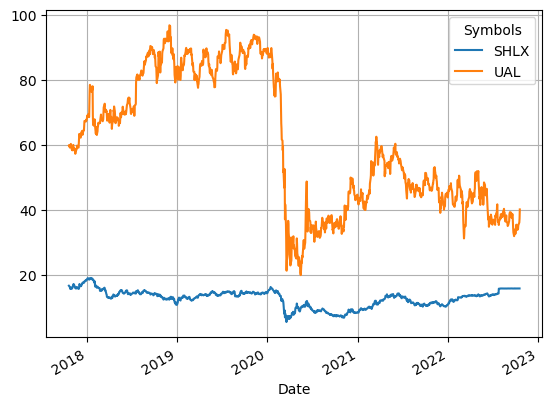

In [6]:
# Gráfica
datos.plot(grid=True)

## 2. Simulación de rendimientos diarios

Recordemos que los precios diarios de cierre ajustados no son un proceso estocástico estacionario, pero los rendimientos diarios si lo son. Por tanto calculamos los rendimientos a partir de los precios de cierre, obtenemos sus propiedades estadísticas muestrales y proyectamos los rendimientos. Luego, obtenemos la proyección de los precios.

Para una sucesión de precios $\{S_t\}_{t=0}^{n}$, el rendimiento simple $R_t$ se define como el cambio porcentual

$$
R_t=\frac{S_t-S_{t-1}}{S_{t-1}}\approx \ln\left(\frac{S_t}{S_{t-1}}\right)=r_t.
$$
para $t=1,\ldots,n$.

Para el ejemplo en curso, ¿cómo calcular esto?

Además, supusimos que los rendimientos diarios eran una variable aleatoria con distribución normal (que se caracteriza con su media y varianza). Por tanto obtenemos la media y desviación estandar muestrales. Hagamos una función que retorne lo anterior.

In [7]:
R=((datos-datos.shift())/datos.shift()).dropna()
R.head()

Symbols,SHLX,UAL
Date,,
2017-10-20,-0.005144,0.002007
2017-10-23,-0.022526,-0.013356
2017-10-24,0.000378,0.013706
2017-10-25,-0.034366,0.000167
2017-10-26,0.014861,0.000501


In [8]:
r=np.log(datos/datos.shift()).dropna()
r.head()

Symbols,SHLX,UAL
Date,,
2017-10-20,-0.005157,0.002005
2017-10-23,-0.022783,-0.013446
2017-10-24,0.000378,0.013613
2017-10-25,-0.034970,0.000167
2017-10-26,0.014752,0.000501


array([[<AxesSubplot:title={'center':'SHLX'}>,
        <AxesSubplot:title={'center':'UAL'}>]], dtype=object)

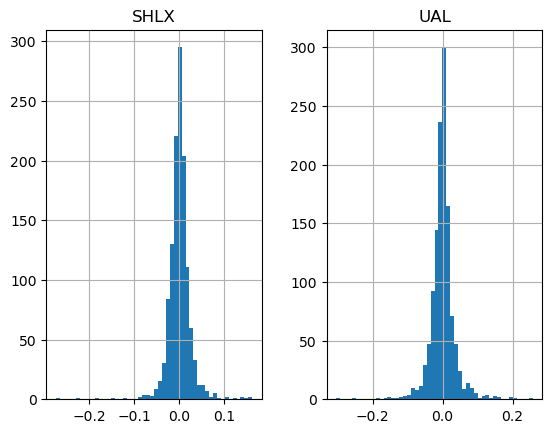

In [9]:
R.hist(bins=50)

array([[<AxesSubplot:title={'center':'SHLX'}>,
        <AxesSubplot:title={'center':'UAL'}>]], dtype=object)

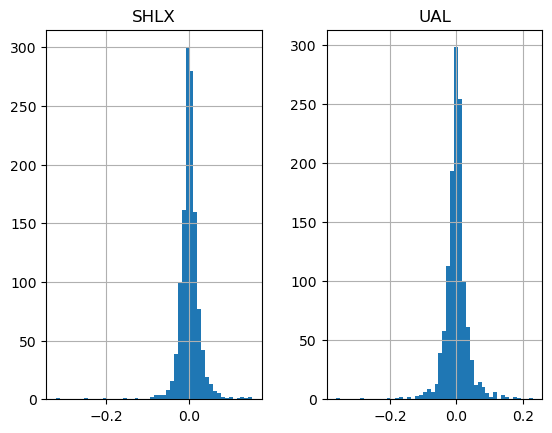

In [10]:
r.hist(bins=50)

In [11]:
# Calculamos media y desviación estandar de 'R'
m=R.mean()
s=R.std()
m,s

(Symbols
 SHLX    0.000313
 UAL     0.000306
 dtype: float64,
 Symbols
 SHLX    0.026284
 UAL     0.036788
 dtype: float64)

In [12]:
m['SHLX']

0.0003127873463079954

Entonces, suponemos que el cambio porcentual de los precios (rendimientos diarios) tiene una distribución normal.

¿Cómo se caracteriza una [distribución normal](https://es.wikipedia.org/wiki/Distribuci%C3%B3n_normal)?

In [13]:
np.random.normal?

In [15]:
import matplotlib.pyplot as plt

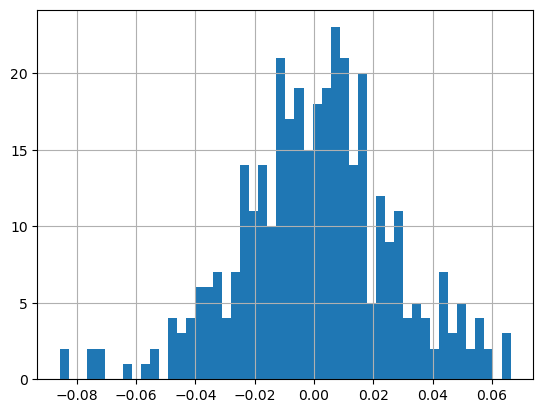

In [17]:
R_SHLX=np.random.normal(m['SHLX'],s['SHLX'],365)  # Simulando 365 días
plt.hist(R_SHLX,bins=50)
plt.grid()

In [19]:
R_SHLX=np.random.normal(m['SHLX'],s['SHLX'],(365,10)) # Simulando 10 escenarios de 365 días
pd.DataFrame(R_SHLX).head()

,0,1,2,3,4,5,6,7,8,9
0,0.008597,0.023333,0.017597,0.005663,0.047745,0.006814,0.061462,-0.046663,0.008278,0.004333
1,0.050001,-0.008640,0.048560,0.017210,-0.025656,0.006151,0.010706,-0.011935,-0.025268,-0.019148
2,0.028366,0.037008,-0.013699,-0.000019,0.015406,0.015216,0.002282,-0.017459,-0.022049,0.007430
3,0.030055,-0.028340,0.028794,0.029199,0.019398,-0.021047,-0.023050,-0.002739,0.020908,-0.007613
4,-0.009722,0.005021,0.044658,0.004905,-0.004014,0.029461,-0.003109,0.052179,0.005797,-0.015702


In [20]:
pd.date_range?

In [21]:
pd.date_range('2022-10-19',periods=365)

DatetimeIndex(['2022-10-19', '2022-10-20', '2022-10-21', '2022-10-22',
               '2022-10-23', '2022-10-24', '2022-10-25', '2022-10-26',
               '2022-10-27', '2022-10-28',
               ...
               '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12',
               '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16',
               '2023-10-17', '2023-10-18'],
              dtype='datetime64[ns]', length=365, freq='D')

In [22]:
R_SHLX=pd.DataFrame(np.random.normal(m['SHLX'],s['SHLX'],(365,100)),index=pd.date_range('2022-10-19',periods=365))
R_SHLX.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2022-10-19,0.000553,-0.021878,0.007492,0.007988,0.004574,-0.021699,0.025870,-0.029868,0.057039,-0.037808,...,0.033188,-0.017130,0.001103,-0.012628,-0.033069,-0.021026,-0.039032,0.016586,-0.005814,-0.009840
2022-10-20,0.002065,-0.018645,0.011315,0.036789,0.017339,-0.003470,0.026415,-0.027987,-0.008079,0.008334,...,0.051102,0.020117,0.020951,0.035931,0.021181,-0.047457,0.023481,-0.025499,0.031183,0.060316
2022-10-21,0.021244,-0.044453,-0.028073,0.050665,-0.005166,-0.018144,0.003385,0.011616,-0.045063,-0.016272,...,0.044306,-0.014054,0.009975,0.023692,0.026064,-0.019076,-0.022106,-0.020189,0.010585,-0.006265
2022-10-22,-0.026866,0.027820,-0.034272,0.043812,0.015269,-0.017959,0.029494,-0.012610,-0.042080,-0.009159,...,0.052972,-0.037918,-0.005749,0.040222,-0.020957,-0.021292,-0.034247,-0.022377,0.005364,-0.025583
2022-10-23,-0.043875,0.028942,0.012889,0.020115,0.019442,0.001986,-0.012419,0.016296,-0.006644,-0.010843,...,0.012951,-0.002967,-0.022154,0.007634,-0.013980,0.012478,0.027905,0.016290,0.009572,0.051094


Habiendo caracterizado los rendimientos diarios como una variable aleatoria normal con la media y la varianza muestral obtenida de los datos del 2018, podemos generar números aleatorios con estas características para simular el comportamiento de los precios de cierre de las acciones en el 2019 (hay un supuesto de que las cosas no cambiarán fundamentalmente).

Sin embargo, cada simulación que hagamos nos conducirá a distintos resultados (los precios siguen evolucionando aleatoriamente). Entonces, lo que haremos es simular varios escenarios para así ver alguna tendencia y tomar decisiones.

Hagamos una una función que simule varios escenarios de rendimientos diarios y que devuelva un dataframe con esta simulación.

In [23]:
def simR(m,s,dias,N,start):
    rango=pd.date_range(start,periods=dias) # pd.date_range(start,end)
    return pd.DataFrame(np.random.normal(m,s,(dias,N)),index=rango)

In [25]:
datos['UAL'].iloc[-1]

40.11000061035156

In [44]:
R_UAL=simR(m['UAL'],s['UAL'],365,1000,'2022-10-19')
R_UAL.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2022-10-19,0.031081,-0.065880,0.010022,0.007665,0.012043,-0.033442,0.061794,-0.048442,0.027445,0.011593,...,0.030907,-0.037241,-0.007795,0.017669,0.017966,0.047699,-0.009515,0.009668,-0.018632,-0.010732
2022-10-20,0.011893,0.040754,-0.043871,-0.018047,-0.035068,-0.024632,0.023669,0.044872,0.004816,0.026513,...,-0.027880,0.047850,0.093571,-0.008876,-0.016873,0.015964,0.031986,0.004101,0.002028,-0.013763
2022-10-21,0.009352,0.069254,-0.033147,0.064613,-0.040721,0.023684,0.028224,0.029751,0.005987,-0.042872,...,-0.014012,0.009531,0.007392,0.018675,-0.057960,0.020567,0.036587,0.024592,0.011132,-0.025705
2022-10-22,-0.025077,-0.071183,0.019079,0.035514,0.010943,0.039202,-0.084772,0.001605,-0.030738,0.041472,...,-0.016329,-0.006309,-0.005494,0.017801,-0.031212,-0.062972,-0.039639,-0.036417,-0.126204,-0.010070
2022-10-23,0.035370,-0.022033,-0.043051,-0.045431,0.022895,-0.023384,-0.013347,0.011610,-0.007925,-0.022018,...,-0.017532,0.038802,-0.022637,0.028705,-0.060073,-0.003805,-0.029696,-0.035863,0.026459,0.008540


## 3. Proyección de precios de cierre

Por tanto, para calcular los precios, tenemos:

$$\begin{align}
p_i&=p_{i-1}(R_i+1)\\
p_{i+1}&=p_i(R_{i+1}+1)=p_{i-1}(R_i+1)(R_{i+1}+1)\\
&\vdots\\
p_{i+k}&=p_{i-1}(R_i+1)\cdots(R_{i+k}+1).
\end{align}$$

Si hacemos $i=0$ en la última ecuación, tenemos que $p_{k}=p_{-1}(R_0+1)\cdots(R_{k}+1)$, donde $p_{-1}$ es el último precio reportado en el 2018.

Con los rendimientos, calculamos los precios de cierre...

In [27]:
(R_SHLX+1).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2022-10-19,1.000553,0.978122,1.007492,1.007988,1.004574,0.978301,1.025870,0.970132,1.057039,0.962192,...,1.033188,0.982870,1.001103,0.987372,0.966931,0.978974,0.960968,1.016586,0.994186,0.990160
2022-10-20,1.002065,0.981355,1.011315,1.036789,1.017339,0.996530,1.026415,0.972013,0.991921,1.008334,...,1.051102,1.020117,1.020951,1.035931,1.021181,0.952543,1.023481,0.974501,1.031183,1.060316
2022-10-21,1.021244,0.955547,0.971927,1.050665,0.994834,0.981856,1.003385,1.011616,0.954937,0.983728,...,1.044306,0.985946,1.009975,1.023692,1.026064,0.980924,0.977894,0.979811,1.010585,0.993735
2022-10-22,0.973134,1.027820,0.965728,1.043812,1.015269,0.982041,1.029494,0.987390,0.957920,0.990841,...,1.052972,0.962082,0.994251,1.040222,0.979043,0.978708,0.965753,0.977623,1.005364,0.974417
2022-10-23,0.956125,1.028942,1.012889,1.020115,1.019442,1.001986,0.987581,1.016296,0.993356,0.989157,...,1.012951,0.997033,0.977846,1.007634,0.986020,1.012478,1.027905,1.016290,1.009572,1.051094


In [29]:
(R_SHLX+1).cumprod().head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
2022-10-19,1.000553,0.978122,1.007492,1.007988,1.004574,0.978301,1.025870,0.970132,1.057039,0.962192,...,1.033188,0.982870,1.001103,0.987372,0.966931,0.978974,0.960968,1.016586,0.994186,0.990160
2022-10-20,1.002619,0.959885,1.018892,1.045071,1.021992,0.974906,1.052969,0.942981,1.048499,0.970211,...,1.085985,1.002642,1.022078,1.022850,0.987412,0.932514,0.983533,0.990664,1.025187,1.049883
2022-10-21,1.023918,0.917215,0.990288,1.098020,1.016712,0.957217,1.056533,0.953934,1.001251,0.954424,...,1.134101,0.988551,1.032273,1.047083,1.013149,0.914726,0.961790,0.970663,1.036039,1.043305
2022-10-22,0.996410,0.942732,0.956349,1.146125,1.032236,0.940026,1.087695,0.941905,0.959118,0.945682,...,1.194177,0.951067,1.026339,1.089199,0.991916,0.895250,0.928852,0.948943,1.041596,1.016614
2022-10-23,0.952693,0.970017,0.968676,1.169180,1.052305,0.941893,1.074187,0.957254,0.952746,0.935428,...,1.209643,0.948246,1.003602,1.097514,0.978049,0.906420,0.954771,0.964402,1.051566,1.068557


In [33]:
datos.tail()

Symbols,SHLX,UAL
Date,,
2022-10-13,15.82,35.400002
2022-10-14,15.82,35.470001
2022-10-17,15.83,36.099998
2022-10-18,15.82,37.250000
2022-10-19,NaN,40.110001


In [38]:
datos.drop?

In [37]:
# datos.drop('2022-10-19',inplace=True)

Symbols,SHLX,UAL
Date,,
2017-10-19,16.660089,59.779999
2017-10-20,16.574398,59.900002
2017-10-23,16.201046,59.099998
2017-10-24,16.207170,59.910000
2017-10-25,15.650200,59.919998
...,...,...
2022-10-11,15.820000,33.930000
2022-10-12,15.820000,34.230000
2022-10-13,15.820000,35.400002


In [39]:
# datos=datos.iloc[:-1]

Symbols,SHLX,UAL
Date,,
2017-10-19,16.660089,59.779999
2017-10-20,16.574398,59.900002
2017-10-23,16.201046,59.099998
2017-10-24,16.207170,59.910000
2017-10-25,15.650200,59.919998
...,...,...
2022-10-11,15.820000,33.930000
2022-10-12,15.820000,34.230000
2022-10-13,15.820000,35.400002


In [34]:
datos.drop(index='2022-10-19',inplace=True)
datos.tail()

Symbols,SHLX,UAL
Date,,
2022-10-12,15.82,34.230000
2022-10-13,15.82,35.400002
2022-10-14,15.82,35.470001
2022-10-17,15.83,36.099998
2022-10-18,15.82,37.250000


<AxesSubplot:>

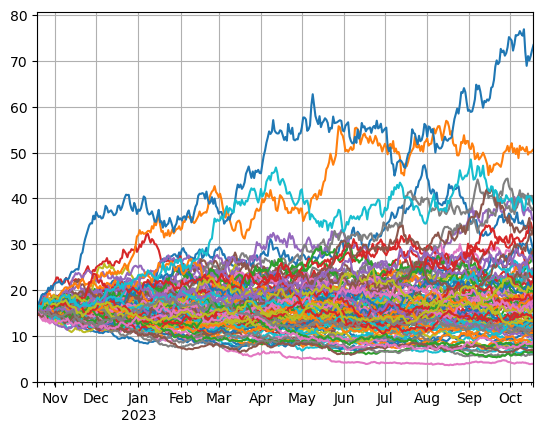

In [35]:
SHLX=datos['SHLX'].iloc[-1]*(R_SHLX+1).cumprod()
SHLX.plot(legend=False,grid=True)

## 4. Probabilidad Precio-Umbral

Ya que tenemos muchos escenarios de precios proyectados, podemos ver varias cosas. Por ejemplo, ¿cuál es la probabilidad de que el precio de cierre sobrepase algún valor umbral en algún momento?

In [40]:
# Umbral = Retorno del 20%
U_SHLX=datos['SHLX'].iloc[-1]*1.2
U_SHLX

18.98399963378906

<AxesSubplot:>

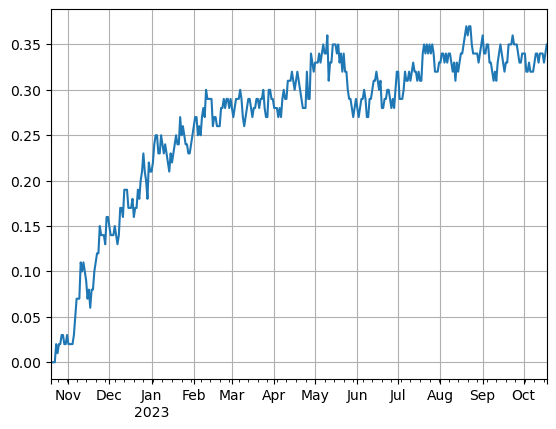

In [42]:
B_SHLX=SHLX>U_SHLX # Variable de Barnoulli
P_SHLX=B_SHLX.mean(axis=1)
P_SHLX.plot(grid=True)

<AxesSubplot:>

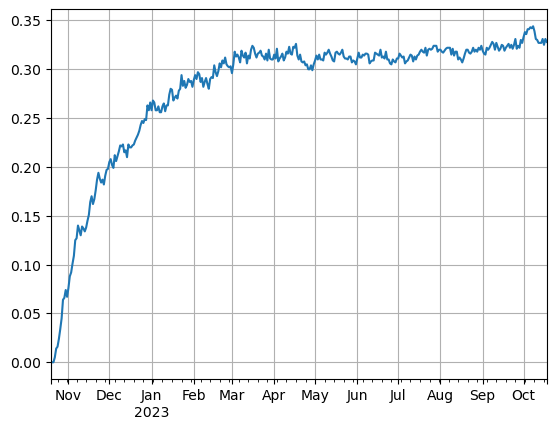

In [45]:
UAL=datos['UAL'].iloc[-1]*(R_UAL+1).cumprod()
U_UAL=datos['UAL'].iloc[-1]*1.2
B_UAL=UAL>U_UAL
P_UAL=B_UAL.mean(axis=1)
P_UAL.plot(grid=True)

___
Entonces, ya aprendimos a bajar datos con pandas-datareader. En específico, a partir de los precios de cierre ajustados obtuvimos los rendimientos diarios.

Suponiendo que los rendimientos diarios son un proceso estocástico estacionario de distribución normal, pudimos caracaterizarlo y proyectar varios escenarios de evolución de los precios (montecarlo).

Con estas proyecciones pudimos calcular probabilidades de sobrepasar cierto precio umbral: toma de decisiones.